## Import libraries

In [1]:
import os
import gc
import glob
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import utils

import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split as TTS
from sklearn.metrics import roc_auc_score

import torch.nn.functional as F

import sys
#sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
import timm
import pickle


### Set random seed and device

In [2]:
device='cuda' if  torch.cuda.is_available() else 'cpu'
print("Your device has "+device+" and we're going to use")

Your device has cuda and we're going to use


In [3]:
np.random.seed(7)
torch.manual_seed(7)

### Ceate dataset Paths list

In [4]:
from Util import img_paths_list

data_root_dir = r'../Model_I/*/*'
dataset_img_paths_list, class_map = img_paths_list(data_root_dir)

Dataset Distribution:

{'no_sub': 28856, 'axion': 28897, 'cdm': 29772}


Class indices:

{'no_sub': 0, 'axion': 1, 'cdm': 2}


  0%|          | 0/87525 [00:00<?, ?it/s]

### Data spliting

In [5]:
from Util import data_split
train_set_image_paths_list , test_set_image_paths_list = data_split(dataset_img_paths_list)
print(len(train_set_image_paths_list), len(test_set_image_paths_list))

78772 8753


### Create Transfroms

In [6]:
from Util import create_transforms
transforms = create_transforms()

### Define a batch size of 64

In [7]:
BS = 64

### Custom Data set

In [8]:
from CustomDataSet import CustomDataset

train_dataset = CustomDataset(train_set_image_paths_list, class_map, transform = transforms)
print(len(train_dataset))


test_set = CustomDataset(test_set_image_paths_list, class_map, transform = transforms)
print(len(test_set))

78772
8753


### Train,test and valid split

In [9]:
from Util import split_train_valid_test
train_set,val_set = split_train_valid_test(train_dataset=train_dataset, test_set= test_set)

Total training data: 78772
len of train,valid,test:  70894 7878 8753


In [10]:
from Util import load_data
train_loader, val_loader, test_loader = load_data(train_set= train_set,test_set= test_set,val_set= val_set, batch_size=BS)


len of train,val,test loaders: 1108 124 137


### Hyper parameters

In [11]:
num_epochs = 50
num_classes = 3
batch_size = BS
learning_rate = 0.001

## Model Architecture

In [12]:
class net(nn.Module):
    def __init__(self):
        super(net, self).__init__()

        
        self.fcl1 = nn.Linear(1000, 512)
        self.bnl1 =  nn.BatchNorm1d(512)


        self.fcl2 = nn.Linear(512, 256)
        self.bnl2 =  nn.BatchNorm1d(256)


        self.fcl3 = nn.Linear(256, 128)
        self.bnl3 =  nn.BatchNorm1d(128)


        self.fcl4 = nn.Linear(128, 3)        


        self.drl = nn.Dropout(0.1)
    
    def forward(self, x):

        
        # branch a
        x = F.leaky_relu(self.fcl1(x))
        x = self.bnl1(x)
        x = self.drl(x)


        x = F.leaky_relu(self.fcl2(x))
        x = self.bnl2(x)
        x = self.drl(x)


        x = F.leaky_relu(self.fcl3(x))
        x = self.bnl3(x)
        x = self.drl(x)

        x = self.fcl4(x)
        
        return x

In [13]:

from torchvision.models import resnet18 
model = resnet18(pretrained=True) # You should put 'True' here 
model.conv1 = torch.nn.Conv1d(1, 64, (7, 7), (2, 2), (3, 3), bias=False)


loss_fn     = torch.nn.CrossEntropyLoss()
optimizer   = torch.optim.Adam(model.parameters(), lr = 3e-5)
criterion = nn.CrossEntropyLoss()

model = model.to(device)



### Create model, set to GPU and make it ready to train

In [14]:
net_add=net()
model = nn.Sequential(model, net_add)
model = model.to(device)

## Train and validation

In [15]:
%%time
# keeping-track-of-losses 
train_losses = []
valid_losses = []

train_acc = []
valid_acc = []

min_loss = 1000


for epoch in range(1, num_epochs + 1):
    # keep-track-of-training-and-validation-loss
    train_loss = 0.0 ;     valid_loss = 0.0
    correct_train = 0 ;     correct_valid = 0


    # training-the-model
    model.train(True)
    for data, target in train_loader:
        # move-tensors-to-GPU 
        data = data.to(device)
        target = target.to(device)
        
        # clear-the-gradients-of-all-optimized-variables
        optimizer.zero_grad()
        # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
        output = model(data)
        # calculate-the-batch-loss
        loss = criterion(output, target)
        # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
        loss.backward()
        # perform-a-ingle-optimization-step (parameter-update)
        optimizer.step()
        # update-training-loss
        train_loss += loss.item() * data.size(0)


        _, predicted = torch.max(output.data, 1)
        correct_train += torch.sum(predicted == target).to(torch.float32)

    accuracy_train = correct_train / len(train_set)
        
    # validate-the-model
    model.train(False)
    model.eval()
    for data, target in val_loader:
        
        data = data.to(device)
        target = target.to(device)
        
        output = model(data)
        
        loss = criterion(output, target)
        
        # update-average-validation-loss 
        valid_loss += loss.item() * data.size(0)

        _, predicted = torch.max(output.data, 1)
        correct_valid += torch.sum(predicted == target).to(torch.float32)

    accuracy_valid =correct_valid / len(val_set)
    
    # calculate-average-losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(val_loader.sampler)


    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    train_acc.append(accuracy_train.item())
    valid_acc.append(accuracy_valid.item())        


    # Report

    print("Epoch :" , epoch) 

    print("Loss Train:" , train_loss)
    print("Loss Valid:" , valid_loss)


    print("Acc  Train:" , accuracy_train.item())
    print("Acc  Valid:" , accuracy_valid.item())

    if epoch == num_epochs:
        torch.save(model, r'../Model/last-model.pt')
        torch.save(model.state_dict(), r'../Model/last-model-parameters.pt')

    if  min_loss > valid_loss: 
        min_loss = valid_loss
        torch.save(model, r'../Model/best-model.pt')
        torch.save(model.state_dict(), r'../Model/best-model-parameters.pt')
        print('!!!New Weights!!!')
    print("---------------------------------------------------------")

Epoch : 1
Loss Train: 0.8566361873998095
Loss Valid: 0.5260702323742583
Acc  Train: 0.5813326835632324
Acc  Valid: 0.7773546576499939
!!!New Weights!!!
---------------------------------------------------------
Epoch : 2
Loss Train: 0.43830303851951513
Loss Valid: 0.3759166783496915
Acc  Train: 0.8254859447479248
Acc  Valid: 0.849708080291748
!!!New Weights!!!
---------------------------------------------------------
Epoch : 3
Loss Train: 0.3423488319691951
Loss Valid: 0.378659090465566
Acc  Train: 0.8651084899902344
Acc  Valid: 0.8570703268051147
---------------------------------------------------------
Epoch : 4
Loss Train: 0.29471093946395516
Loss Valid: 0.2942519436790635
Acc  Train: 0.8845882415771484
Acc  Valid: 0.8847423195838928
!!!New Weights!!!
---------------------------------------------------------
Epoch : 5
Loss Train: 0.2678585189811117
Loss Valid: 0.2676036630991934
Acc  Train: 0.8933054804801941
Acc  Valid: 0.8931201100349426
!!!New Weights!!!
--------------------------

## Test with the last's epochs weights

In [ ]:
# ## load last epoch weights and test
# test_loss = 0.0
# correct_test = 0

# last_model = CNN()
# last_model.cuda()
# last_model.load_state_dict(torch.load('../Model/last-model-parameters.pt'))
# last_model.eval()
# for data, target in test_loader:
    
#     data = data.to(device)
#     target = target.to(device)
    
#     output = last_model(data)
    
#     loss = criterion(output, target)
    
#     # update-average-test-loss 
#     test_loss += loss.item() * data.size(0)

#     _, predicted = torch.max(output.data, 1)
#     correct_test += torch.sum(predicted == target).to(torch.float32)

# accuracy_test =correct_test / len(test_set)
# # calculate-average-losses
# test_loss = test_loss/len(test_loader.sampler)




# # Report
# print('Last epoch model')

# print("correct test :" , correct_test)
# print("len test_loader_sampler :" , len(test_loader.sampler)) 
# print("len test_set :" , len(test_set)) 


# print("Loss Test:" , test_loss)


# print("Acc  Test:" , accuracy_test.item())

# print("-------------------------------------")

Last epoch model
correct test : tensor(7126., device='cuda:0')
len test_loader_sampler : 8753
len test_set : 8753
Loss Test: 0.4540597452690271
Acc  Test: 0.8141208291053772
-------------------------------------


## Test with best parametrs

In [17]:
## load best weights and test
test_loss = 0.0
correct_test = 0

saved_model = model
saved_model.cuda()
saved_model.load_state_dict(torch.load('../Model/best-model-parameters.pt'))
saved_model.eval()
for data, target in test_loader:
    
    data = data.to(device)
    target = target.to(device)
    
    output = saved_model(data)
    
    loss = criterion(output, target)
    
    # update-average-test-loss 
    test_loss += loss.item() * data.size(0)

    _, predicted = torch.max(output.data, 1)
    correct_test += torch.sum(predicted == target).to(torch.float32)

accuracy_test =correct_test / len(test_set)
# calculate-average-losses
test_loss = test_loss/len(test_loader.sampler)




# Report
print('Best model')
print("correct test :" , correct_test)
print("len test_loader_sampler :" , len(test_loader.sampler)) 
print("len test_set :" , len(test_set))  

print("Loss Test:" , test_loss)


print("Acc  Test:" , accuracy_test.item())

print("-------------------------------------")

Best model
correct test : tensor(7946., device='cuda:0')
len test_loader_sampler : 8753
len test_set : 8753
Loss Test: 0.22604665229296828
Acc  Test: 0.9078029990196228
-------------------------------------


## Ploting results

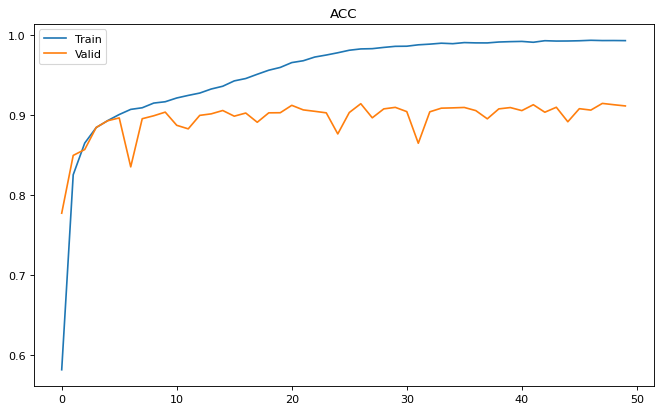

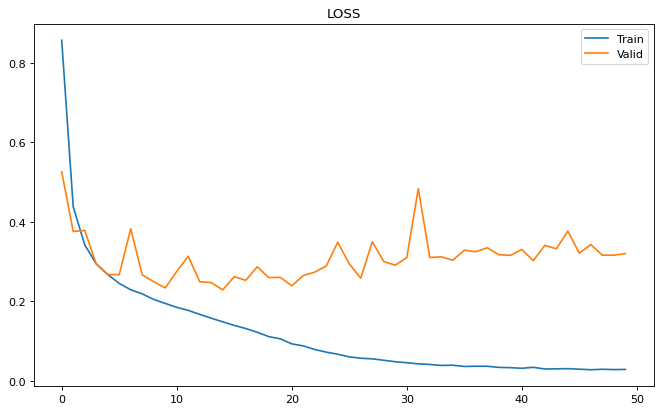

In [16]:
from matplotlib.pyplot import figure

figure(figsize=(10, 6), dpi=80)
plt.plot(train_acc ,label="Train")
plt.plot(valid_acc ,label="Valid")
plt.title("ACC")
plt.legend()

plt.show()



figure(figsize=(10, 6), dpi=80)
plt.plot(train_losses ,label="Train")
plt.plot(valid_losses, label="Valid")
plt.title("LOSS")
plt.legend()

plt.show()

